# Apprentissage fédéré de réseaux de neurones
# Lionel Delphin-Poulat, Bassem Jaber, Nour El Houda Zribi
Ce projet a pour objectif de comparer les performances d'un apprentissage classique à un apprentissage fédéré dans le cas d'un réseau de neurones entraîné avec les données du Challenge DCASE 2018 disponibles ici :"http://dcase.community/challenge2018/task-general-purpose-audio-tagging"


Nous commençons par importer l'ensemble des bibliothèques et fonctions auxiliaires qui nous servirons dans ce projet.\
Attention à l'utilisation de tensorflow, lorsque vous installez tensorflow-gpu, il faut faire le nécessaire pour que les calculs se fassent correctement sur votre carte graphique, lire la documentation dans les sites suivant pour effectuer la démarche correspondante (https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html https://www.tensorflow.org/install/gpu https://developer.nvidia.com/cudnn )\
Dans le cas où votre carte graphique n'est pas compatible où que l'installation ne se déroule pas comme souhaité, installez simplement tensorflow et les calculs s'effectueront sur le processeur, mais ce dernier possède en général une puissance de calcul beaucoup plus faible.

In [1]:
#!pip install keras
#!pip install tensorflow-gpu
#!pip install soundfile
#!pip install librosa
#!pip install tensorboard
import soundfile
import librosa
import numpy as np
import pandas as pd
import keras
import os
import sklearn.utils
import keras.backend as K
import tensorflow
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.layers import BatchNormalization, Activation, Conv2D, MaxPooling2D, Input, Dropout, Dense, Flatten, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint, TensorBoard
%load_ext tensorboard

Using TensorFlow backend.


Nous définissons la fonction suivante pour ré-échantilloner le fichier si nécessaire et surtout obtenir les amplitudes du fichier son analysé.

In [2]:
def get_sound_data(filename, sr=None):
    """
    read sound file, convert it to a target frequency and convert it to mono
    
    Parameters
    ----------
    filename: str
        sound filename
    sr: int
        sampling rate in Hz
    
    Returns
    -------
    data: ndarray
        an ndarray of amplitude values
    sr: int
        the sampling frequency of the returned signal
    """
    
    # read the sound file
    data, fsr = soundfile.read(filename)
    
    # resample if required
    if sr is not None and sr != fsr:
        data_resample = librosa.resample(data.T, fsr, sr)
    else:
        data_resample = data.T
        sr = fsr
    
    # if there is more than one audio channel
    # convert to mono by averaging over all the channels
    if len(data_resample.shape) > 1:
        data_resample = np.average(data_resample, axis=0)
        
    return data_resample, sr

Nous définissons maintenant les fonctions qui nous permettront de définir notre réseau de neurones.\
Nous commençons par définir un bloc de notre réseau puis le modèle global.

In [3]:
def vggish_convolution_block(input,
                             kernel_size=(3, 3),
                             filters=128,
                             pool_size=(2, 2),
                             pool_strides=(2, 2),
                             padding='same',
                             data_format='channels_first',
                             drop_out=None,
                             use_bias=False):
    """
    Define a vggish convolution block

    Parameters
    ----------
    input :
        input Tensor
    kernel_size : `int` or `tuple`
        kernel filter sizes
    filters :
        number of output units
    pool_size :
        sizes for max-pooling at model output
    pool_strides :
        strides for max-pooling at mode output
    padding : str
        padding format for convolution layers
    data_format : str
        data format to indicate the channel position
    drop_out : bool
        add dropout layer after activation funcion
    use_bias : bool
        add bias parameters
    Returns
    -------
    Tensor
        output tensor
    """

    naxis = 1 if data_format == 'channels_first' else -1

    cnn = Conv2D(filters,
                 kernel_size=kernel_size,
                 padding=padding,
                 data_format=data_format,
                 use_bias=use_bias,
                 kernel_initializer='he_uniform')(input)

    cnn = BatchNormalization(axis=naxis)(cnn)

    cnn = Activation('relu')(cnn)

    if drop_out is not None:
        cnn = Dropout(rate=drop_out)(cnn)

    cnn = Conv2D(filters,
                 kernel_size=kernel_size,
                 padding=padding,
                 data_format=data_format,
                 use_bias=use_bias,
                 kernel_initializer='he_uniform')(cnn)

    cnn = BatchNormalization(axis=naxis)(cnn)

    cnn = Activation('relu')(cnn)

    cnn = MaxPooling2D(pool_size=pool_size,
                       strides=pool_strides,
                       data_format=data_format)(cnn)

    if drop_out is not None:
        cnn = Dropout(rate=drop_out)(cnn)

    return cnn

In [4]:
def vggish_model(input_shape,
                 classes,
                 other_class=True,
                 filters=[64, 128, 256, 512],
                 n_layers=None,
                 kernel_size=(3, 3),
                 pool_size=(2, 2),
                 data_format='channels_first',
                 drop_out=None,
                 output_activation='softmax'):
    if isinstance(input_shape, list):
        input_layer = Input(input_shape[0], name='spectrogram')
        auxiliary_input = Input(input_shape[1], name="auxiliary")
    else:
        input_layer = Input(input_shape, name='spectrogram')
        auxiliary_input = None

    current_layer = input_layer

    use_bias = False
    padding = 'same'

    class_count = classes if other_class else classes - 1
    dense_dropout = 0.2

    if not isinstance(filters, list):
        if n_layers is None:
            raise ValueError("n_layers can not be none if filters is not a list")
        filter_list = n_layers * [filters]
    else:
        filter_list = filters
        n_layers = len(filters)

    for layer in range(n_layers):
        current_layer = vggish_convolution_block(current_layer,
                                                 kernel_size=kernel_size,
                                                 filters=filter_list[layer],
                                                 pool_size=pool_size,
                                                 padding=padding,
                                                 data_format=data_format,
                                                 use_bias=use_bias,
                                                 drop_out=drop_out)

    #    current_layer = GlobalMaxPooling2D(data_format=data_format)(current_layer)

    layer_shape = K.int_shape(current_layer)

    if data_format == 'channels_first':
        pool_size = layer_shape[2:]
    else:
        pool_size = layer_shape[1:-1]

    current_layer = MaxPooling2D(pool_size=pool_size,
                                 strides=pool_size,
                                 data_format=data_format)(current_layer)

    current_layer = Flatten(data_format=data_format)(current_layer)

    current_layer = Dropout(rate=dense_dropout)(current_layer)

    if auxiliary_input is not None:
        current_layer = concatenate([current_layer, auxiliary_input])

    # current_layer = Dropout(rate=dense_dropout)(current_layer)
    current_layer = Dense(units=class_count,
                          kernel_initializer='he_uniform',
                          activation=output_activation)(current_layer)

    if auxiliary_input is not None:
        model = Model([input_layer, auxiliary_input], current_layer)
    else:
        model = Model(input_layer, current_layer)

    return model

Nous définissons ici le Data Generator.\
Son rôle est de gagner du temps de calcul lors de l'apprentissage.\
Au lieu de balayer toute notre base de données à chacun de nos calculs pour chaque batch de données, il ne va prendre en compte que les données pertinentes au calcul en question et ne pas charger le reste de la base de données, cela permet d'économiser du temps de calcul et de la RAM, ce qui nous est très utile pour accélérer l'apprentissage.

In [5]:
# =====================================================================
# Class: Data generator
# =====================================================================

class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 train_filename_list,
                 labels,
                 samples_directory,
                 batch_size=256,
                 undersampling='uniform',
                 shuffle=True,
                 frame_window_length=None,
                 frame_window_hop=None,
                 data_format='channels_first',
                 debug=False):
        """Data generator

        Parameters
        ----------
        train_filename_list : list of str
           list of file base names

        labels : ndarray
           labels

        samples_directory : str
            directory where to find the data

        batch_size : int
           Batch size

        undersampling : str ('uniform','none')
           Uniform undersampling or none

        shuffle : bool
           shuffle ont epoch end

        separate_channels : bool
            process each channel separately

        frame_window_length : int
            number of frames for a patch. If nothing is provided, the whole file is considered as input

        frame_window_hop : int
            number of frames between two windows. This parameter is ignored if frame_window_length is None

        data_format : {'channels_first', 'channels_last'}
            ordering of input dimensions

        debug : bool
            specifies if debug info must be output while generating the data

        """

        # inits
        self.batch_size = batch_size
        self.labels = labels
        self.undersampling = undersampling
        self.train_filename_list = train_filename_list
        self.samples_directory = samples_directory
        self.shuffle = shuffle
        # get the different classes
        classes = np.unique(self.labels)
        # and their count
        self.nr_class = len(classes)
        # compute the least represented class
        class_weight = sklearn.utils.compute_class_weight('balanced', classes, self.labels)
        min_ex = np.argmax(class_weight)
        # compute the number of sample in this class
        self.values_to_sample = np.sum(self.labels == min_ex)

        self.frame_window_length = frame_window_length
        self.frame_window_hop = frame_window_hop

        if self.frame_window_length is not None and self.frame_window_hop is None:
            self.frame_window_hop = self.frame_window_length

        if self.frame_window_length is not None:
            # retrieve the file lengths for all the file in the database
            # it assumes that each numpy file has shape (n_frames, n_frequencies)
            self._file_lengths = []
            for file_id in train_filename_list:
                feature_filename = os.path.join(self.samples_directory, file_id + 'normalized.npy')
                features = np.load(feature_filename)
                self._file_lengths.append(features.shape[0])
        else:
            self._file_lengths = None

        self.data_format = data_format
        self.debug = debug

        self.on_epoch_end()

    def __compute_batches(self):
        """
        get the number of batches

        Returns
        -------
        batches : int
            the number of batches

        """
        self.batches = len(self.indexes) // self.batch_size
        if not self.shuffle:  # not in training mode
            if len(self.indexes) % self.batch_size != 0:
                self.batches += 1
        if self.debug:
            print('number of training batches %s' % self.batches)

    def __len__(self):
        # batch size
        if self.batches < 1:
            self.__compute_batches()
        return self.batches

    def __get_data_from_indexes(self, indexes, start, stop):
        """
        get a batch of data from start

        Parameters
        ----------
        indexes : ndarray
            sample indices of the whole data

        start : int
            index of the first sample to be included in the batch
        stop :
            index of the last sample (not included in the batch)

        Returns
        -------
        data : ndarray
            batch of input data

        label : ndarray
            batch of the corresponding one-hot-encoded labels
        """

        begs = None

        if self.frame_window_length is not None:
            # retrieve the file names and corresponding labels
            training_files_tmp = [self.train_filename_list[k] for k in indexes[start:stop, 0]]
            y_tmp = [self.labels[k] for k in indexes[start:stop, 0]]
            # retrieve the corresponding window start frames
            begs = [k for k in indexes[start:stop, 1]]

        else:
            # retrieve the file names and corresponding labels
            training_files_tmp = [self.train_filename_list[k] for k in indexes[start:stop]]
            y_tmp = [self.labels[k] for k in indexes[start:stop]]

        # get actual data from indices
        X, y = self.__data_generation(training_files_tmp, y_tmp, begs)

        return X, y

    def __getitem__(self, index):
        # Select batch
        start = index * self.batch_size
        stop = min((index + 1) * self.batch_size,
                   self.nr_examples)  # if needed provide smaller batch (used in validation)

        # Generate data
        X, y = self.__get_data_from_indexes(self.indexes, start, stop)

        return X, y

    def __get_patches(self, file_indices):
        """
        compute all the samples that can be obtained from the file given in file_indices.
        each sample is identified by a file id and a start frame within the corresponding file

        Parameters
        ----------
        file_indices: list of int
            numerical indices of feature files

        Returns
        -------
        patches: ndarray (number of samples, 2)
            array of samples indices (index : couple of file id and start frame)
        """
        patches = []
        for file_id in file_indices:
            # get the array of start frames
            begins = get_begins(self._file_lengths[file_id], self.frame_window_length, self.frame_window_hop)
            # for file_id build a two dimensionnal array
            # [[file_id, begs[0]], [file_id, begs[1]],...,  [file_id, begs[n_window-1]]]
            file_ids = np.repeat([file_id], len(begins))
            cur_patch = np.stack((file_ids, begins), axis=-1)
            patches.append(cur_patch)
        return np.concatenate(patches)

    def on_epoch_end(self):
        """

        function that prepares the indices ot the samples that will be used during one training epoch

        """
        if self.debug:
            print("generating shuffle % s" % self.undersampling)
        # undersampling
        if self.undersampling == 'uniform':
            all_indexes = np.arange(len(self.labels))
            self.indexes = [None] * (self.values_to_sample * self.nr_class)

            # print("%d %d" % (self.values_to_sample,  self.nr_class))

            for i in range(self.nr_class):
                # for each class pick-up self.values_to_sample samples
                self.indexes[i * self.values_to_sample: (i + 1) * self.values_to_sample] = \
                    np.random.choice(all_indexes[self.labels == i], self.values_to_sample, replace=False)

            if self.debug:
                print('# of files after undersampling %s' % len(self.indexes))
        else:
            self.indexes = np.arange(len(self.train_filename_list))
            if self.debug:
                print('# of files %s' % len(self.indexes))

        # self.indexes contain the file indices that will be used on this epoch

        # if we need to get smaller patches for each file
        if self.frame_window_length is not None:
            # elements of the array are in the following form
            # [file_id, beginning frame]
            self.indexes = self.__get_patches(self.indexes)

        if self.debug:
            print(self.indexes[:20])

        self.nr_examples = len(self.indexes)

        # shuffle data if required (must be True for training)
        # must be False for test or validation use
        if self.shuffle:
            np.random.shuffle(self.indexes)
            if self.debug:
                print("after shuffle")
                print(self.indexes[:20])

        if self.debug:
            print("shuffle size %d" % len(self.indexes))
            print("indexes shapes {}".format(self.indexes.shape))
            print("indexes dims {}".format(self.indexes.ndim))

        # uptate the number of batches
        self.__compute_batches()

    def __data_generation(self, training_files_tmp, y_tmp, begs=None):
        # Initialization
        x = []

        # prepare one-hot encoding arrays

        y = np.zeros((len(y_tmp), self.nr_class))

        previous_feature_fn = ''
        all_features_data = None
        # Generate data
        for j, ID in enumerate(training_files_tmp):
            # load data
            feature_filename = os.path.join(self.samples_directory, training_files_tmp[j] + 'normalized.npy')

            if self.debug:

                if begs is not None:
                    start_stop = '[%d:%d]' % (begs[j], begs[j] + self.frame_window_length)
                else:
                    start_stop = '[:]'

                print("loading %s %s label %d %s" % (
                    training_files_tmp[j], feature_filename,
                    y_tmp[j],
                    start_stop))

            if previous_feature_fn != feature_filename or all_features_data is None:
                # only load the data when a new file is found
                all_features_data = np.load(feature_filename)
                previous_feature_fn = feature_filename

            features_data = all_features_data

            if begs is not None:
                # we must extract the corresponding signal patch
                beg = begs[j]
                end = begs[j] + self.frame_window_length

                features_data = features_data[beg:end, :]

                if features_data.shape[0] < self.frame_window_length:
                    # the signal is not long enough
                    pad_size = self.frame_window_length - features_data.shape[0]
                    # pad it with 0s
                    features_data = np.pad(features_data, ((0, pad_size), (0, 0)), mode='wrap')

            if self.debug:
                print("features shape {}".format(features_data.shape))

            features_data = np.reshape(features_data,(1,)+features_data.shape)
            x.append(features_data)

            # one hot encoding
            y[j][y_tmp[j]] = 1

        x_data = np.array(x)

        if self.data_format == 'channels_last':
            # move channel axis to the last position
            x_data = np.moveaxis(x_data, [1, 2, 3], [3, 1, 2])

        return x_data, y

    @property
    def file_lengths(self):
        return self._file_lengths


def get_begins(file_length, frame_window_length, frame_window_hop):
    """

    get the frame indices where each window starts;

    Parameters
    ----------
    file_length : int
        total file length in frames

    frame_window_length : int
        window size in frames

    frame_window_hop : int
        window hop in frames

    Returns
    -------
    begins : 'numpy.array'
        an array containing the window starts indices

    """
    if file_length < frame_window_length:
        begins = [0]
    else:
        begins = np.arange(0, file_length - frame_window_length + 1, frame_window_hop)
    return begins


Nous nettoyons notre session keras pour pallier à un problème de fuite de mémoire sur keras apparu avec Windows 10. Cela nous permet de faire différents apprentissages superposés sans encombres.

In [6]:
keras.backend.clear_session()

Nous définissons ici l'ensemble des paramètres utilisés par la suite. Nous chargeons les donnés, définissons les classes, les listes de fichier audio pour l'entraînement, la validation, les tests, etc...

In [7]:
#Parameters
data_label=pd.read_csv('C:/Users/jaber/Downloads/PFE/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')
basename = 'C:/Users/jaber/Downloads/PFE/'
data_train=pd.read_csv('C:/Users/jaber/Downloads/PFE/fold1_train.txt', sep='\t')
train_values=data_train.values
data_valid=pd.read_csv('C:/Users/jaber/Downloads/PFE/fold1_valid.txt', sep='\t')
valid_values=data_valid.values
data_test=pd.read_csv('C:/Users/jaber/Downloads/PFE/fold1_test.txt', sep='\t')
test_values=data_test.values

classes=[]
for i in range(len(data_label['label'].values)):
    cur=data_label['label'].values[i]
    if cur not in classes:
        classes.append(cur)
classes.sort()

train_listwav=[]
listwavtot=[]
train_listlabel=[]
listlabeltot=[]

label_encoder = LabelEncoder()

valid_listwav=[]
valid_listlabel=[]

test_listwav=[]
test_listlabel=[]

n_mels=64
frame_window=62
input_shape = (1,frame_window, n_mels)

train_sortedbylabel={}

Nous définissons ici le dictionnaire des fichiers audio d'entraînement, la clé correspond au label et les données à l'ensemble des fichiers ayant ce label.

In [8]:
for k in range(len(classes)):
    cur=[]
    for i in range(len(train_values)):
        if train_values[i][1]==classes[k]:
            cur.append(train_values[i][0])
            train_sortedbylabel[k]=cur

Nous définissons ici la fonction de création des utilisateurs que nous simulons. Cela revient à subdiviser notre ensemble d'apprentissages en plusieurs sous-ensembles selon des règles de division et de tri.\
Si la division est "even", alors on distribue dans des proportions équitable les exemples entre les utilisateurs.\
Si la division est "random", alors on distribue dans des proportions aléatoires les exemples entre les utilisateurs.\
Si le sorting est "orderly", alors les exemples sont donnés aux utilisateurs dans l'ordre de la trainlist.\
Si le sorting est "random", alors les exemples sont tirés aléatoirement dans la trainlist avant d'être donnés aux utilisateurs.

In [9]:
def CreateUsers(trainlist,nb_users,division,sorting):
    WavList=[]
    DistributionList=[]
    LabelList=[]
    if division=="even" and sorting=="orderly":
        for l in range(nb_users):
            wav=[]
            distrib=[]
            label=[]
            for k in range(len(trainlist)):
                distrib.append(int(np.floor((len(trainlist[k]))/nb_users)))
                for i in range(int(np.floor((len(trainlist[k]))/nb_users))):
                    wav.append(trainlist[k][l*int(np.floor((len(trainlist[k]))/nb_users))+i])
                    label.append(k)
            WavList.append(wav)
            DistributionList.append(distrib)
            LabelList.append(label)
    if division=="random" and sorting=="orderly":
        s = np.random.uniform(0,1,nb_users)
        for l in range(nb_users):
            S=0
            wav=[]
            distrib=[]
            label=[]
            for k in range(len(trainlist)):
                if k==0:
                    S+=int(np.floor((s[l]/np.sum(s))*len(trainlist[k])))
                distrib.append(int(np.floor((s[l]/np.sum(s))*len(trainlist[k]))))
                for i in range(int(np.floor((s[l]/np.sum(s))*len(trainlist[k])))):
                    wav.append(trainlist[k][int(np.floor((S/np.sum(s))))+i])
                    label.append(k)
            WavList.append(wav)
            DistributionList.append(distrib)
            LabelList.append(label)
    if division=="even" and sorting=="random":
        for l in range(nb_users):
            wav=[]
            distrib=[]
            label=[]
            for k in range(len(trainlist)):
                tirage = np.random.choice(len(trainlist[k]), len(trainlist[k]),replace=False)
                distrib.append(int(np.floor((len(trainlist[k]))/nb_users)))
                for i in range(int(np.floor((len(trainlist[k]))/nb_users))):
                    wav.append(trainlist[k][tirage[l*int(np.floor((len(trainlist[k]))/nb_users))+i]])
                    label.append(k)
            WavList.append(wav)
            DistributionList.append(distrib)
            LabelList.append(label)
    if division=="random" and sorting=="random":
        s = np.random.uniform(0,1,nb_users)
        for l in range(nb_users):
            S=0
            wav=[]
            distrib=[]
            label=[]
            for k in range(len(trainlist)):
                tirage = np.random.choice(len(trainlist[k]), len(trainlist[k]),replace=False)
                if k==0:
                    S+=int(np.floor((s[l]/np.sum(s))*len(trainlist[k])))
                distrib.append(int(np.floor((s[l]/np.sum(s))*len(trainlist[k]))))
                for i in range(int(np.floor((s[l]/np.sum(s))*len(trainlist[k])))):
                    wav.append(trainlist[k][tirage[int(np.floor((S/np.sum(s))))+i]])
                    label.append(k)
            WavList.append(wav)
            DistributionList.append(distrib)
            LabelList.append(label)
    return WavList,DistributionList,LabelList

Nous simulons 5 utilisateurs, puis nous visualisons la distribution des données pour un des utilisateur en fonction des labels.

In [10]:
Users=CreateUsers(train_sortedbylabel,5,"even","orderly")

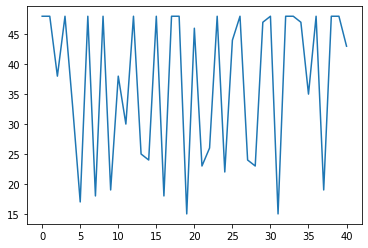

In [11]:
plt.plot(range(len(Users[1][0])),Users[1][0])

Nous effectuons à présent le data pre-processing, nous convertissons nos fichiers audio en fichiers .npy pour ne conserver que le spectrogramme de mel du fichier, que nous convertissons en données chiffrées en dB pour une utilisation future dans notre réseau de neurone, c'est l'unique composante qui nous permettra de différencier les fichiers sons et faire l'apprentissage.\
Nous normalisons par la suite nos données pour améliorer l'apprentissage.\
Nous effectuons également le One-Hot Encoding sur les données de validation et de test pour être cohérent avec les modèles de machine learning que nous utilisons à la suite.

In [12]:
for i in range(len(train_values)):
    train_listwav.append(train_values[i][0])
    listwavtot.append(train_values[i][0])
    train_listlabel.append(train_values[i][1])
    listlabeltot.append(train_values[i][1])
# integer encode
train_label_integer_encoded = label_encoder.fit_transform(train_listlabel)
"""for filename in train_listwav:
    wavename = os.path.join(basename,filename)
    # read the sound file
    data, sr = get_sound_data(wavename)
    # feature computation
    mel_spectrogram = librosa.feature.melspectrogram(data,sr=sr,n_mels=64,hop_length=1024,n_fft=2048,fmin=50)
    logspec_full = librosa.amplitude_to_db(mel_spectrogram)
    np.save('C:/Users/jaber/Downloads/PFE/Features/'+filename, logspec_full.T)"""

"for filename in train_listwav:\n    wavename = os.path.join(basename,filename)\n    # read the sound file\n    data, sr = get_sound_data(wavename)\n    # feature computation\n    mel_spectrogram = librosa.feature.melspectrogram(data,sr=sr,n_mels=64,hop_length=1024,n_fft=2048,fmin=50)\n    logspec_full = librosa.amplitude_to_db(mel_spectrogram)\n    np.save('C:/Users/jaber/Downloads/PFE/Features/'+filename, logspec_full.T)"

In [13]:
for i in range(len(valid_values)):
    valid_listwav.append(valid_values[i][0])
    listwavtot.append(valid_values[i][0])
    valid_listlabel.append(valid_values[i][1])
    listlabeltot.append(valid_values[i][1])
# integer encode
valid_label_integer_encoded = label_encoder.transform(valid_listlabel)
"""for filename in valid_listwav:
    wavename = os.path.join(basename,filename)
    # read the sound file
    data, sr = get_sound_data(wavename)
    # feature computation
    mel_spectrogram = librosa.feature.melspectrogram(data,sr=sr,n_mels=64,hop_length=1024,n_fft=2048,fmin=50)
    logspec_full = librosa.amplitude_to_db(mel_spectrogram)
    np.save('C:/Users/jaber/Downloads/PFE/ValidFeatures/'+filename, logspec_full.T)"""

"for filename in valid_listwav:\n    wavename = os.path.join(basename,filename)\n    # read the sound file\n    data, sr = get_sound_data(wavename)\n    # feature computation\n    mel_spectrogram = librosa.feature.melspectrogram(data,sr=sr,n_mels=64,hop_length=1024,n_fft=2048,fmin=50)\n    logspec_full = librosa.amplitude_to_db(mel_spectrogram)\n    np.save('C:/Users/jaber/Downloads/PFE/ValidFeatures/'+filename, logspec_full.T)"

In [14]:
for i in range(len(test_values)):
    test_listwav.append(test_values[i][0])
    listwavtot.append(test_values[i][0])
    test_listlabel.append(test_values[i][1])
    listlabeltot.append(test_values[i][1])
# integer encode
test_label_integer_encoded = label_encoder.transform(test_listlabel)
"""for filename in test_listwav:
    wavename = os.path.join(basename,filename)
    # read the sound file
    data, sr = get_sound_data(wavename)
    # feature computation
    mel_spectrogram = librosa.feature.melspectrogram(data,sr=sr,n_mels=64,hop_length=1024,n_fft=2048,fmin=50)
    logspec_full = librosa.amplitude_to_db(mel_spectrogram)
    np.save('C:/Users/jaber/Downloads/PFE/TestFeatures/'+filename, logspec_full.T)"""

"for filename in test_listwav:\n    wavename = os.path.join(basename,filename)\n    # read the sound file\n    data, sr = get_sound_data(wavename)\n    # feature computation\n    mel_spectrogram = librosa.feature.melspectrogram(data,sr=sr,n_mels=64,hop_length=1024,n_fft=2048,fmin=50)\n    logspec_full = librosa.amplitude_to_db(mel_spectrogram)\n    np.save('C:/Users/jaber/Downloads/PFE/TestFeatures/'+filename, logspec_full.T)"

In [15]:
"""scaler = StandardScaler()
feature_batch = []
#loop over all feature files in TRAINING SET
for feature_filename in train_listwav:
    # load features
    features = np.load(open('C:/Users/jaber/Downloads/PFE/Features/'+feature_filename+'.npy', 'rb'))
    # append the features to the liste
    feature_batch.append(features)
    # flush the list every 5000 feature file
    if len(feature_batch) % 5000 == 0:
        # transform the list of feature arrays in a T x n_mels array
        feature_batch = np.concatenate(feature_batch)
        # compute
        scaler.partial_fit(feature_batch)
        feature_batch = []
if len(feature_batch) != 0:
    feature_batch = np.concatenate(feature_batch)
    scaler.partial_fit(feature_batch)"""

"scaler = StandardScaler()\nfeature_batch = []\n#loop over all feature files in TRAINING SET\nfor feature_filename in train_listwav:\n    # load features\n    features = np.load(open('C:/Users/jaber/Downloads/PFE/Features/'+feature_filename+'.npy', 'rb'))\n    # append the features to the liste\n    feature_batch.append(features)\n    # flush the list every 5000 feature file\n    if len(feature_batch) % 5000 == 0:\n        # transform the list of feature arrays in a T x n_mels array\n        feature_batch = np.concatenate(feature_batch)\n        # compute\n        scaler.partial_fit(feature_batch)\n        feature_batch = []\nif len(feature_batch) != 0:\n    feature_batch = np.concatenate(feature_batch)\n    scaler.partial_fit(feature_batch)"

In [16]:
 #loop over all feature files
"""for feature_filename in train_listwav:
    # load features
    features = np.load(open('C:/Users/jaber/Downloads/PFE/Features/'+feature_filename+'.npy', 'rb'))
    # normalize features
    normalized_features = scaler.transform(features)
    # store normalized features
    np.save('C:/Users/jaber/Downloads/PFE/NormalizedFeatures/'+feature_filename+'normalized.npy', normalized_features)"""

"for feature_filename in train_listwav:\n   # load features\n   features = np.load(open('C:/Users/jaber/Downloads/PFE/Features/'+feature_filename+'.npy', 'rb'))\n   # normalize features\n   normalized_features = scaler.transform(features)\n   # store normalized features\n   np.save('C:/Users/jaber/Downloads/PFE/NormalizedFeatures/'+feature_filename+'normalized.npy', normalized_features)"

In [17]:
 #loop over all feature files
"""for feature_filename in valid_listwav:
    # load features
    features = np.load(open('C:/Users/jaber/Downloads/PFE/ValidFeatures/'+feature_filename+'.npy', 'rb'))
    # normalize features
    normalized_features = scaler.transform(features)
    # store normalized features
    np.save('C:/Users/jaber/Downloads/PFE/NormalizedValidFeatures/'+feature_filename+'normalized.npy', normalized_features)"""

"for feature_filename in valid_listwav:\n   # load features\n   features = np.load(open('C:/Users/jaber/Downloads/PFE/ValidFeatures/'+feature_filename+'.npy', 'rb'))\n   # normalize features\n   normalized_features = scaler.transform(features)\n   # store normalized features\n   np.save('C:/Users/jaber/Downloads/PFE/NormalizedValidFeatures/'+feature_filename+'normalized.npy', normalized_features)"

In [18]:
 #loop over all feature files
"""for feature_filename in test_listwav:
    # load features
    features = np.load(open('C:/Users/jaber/Downloads/PFE/TestFeatures/'+feature_filename+'.npy', 'rb'))
    # normalize features
    normalized_features = scaler.transform(features)
    # store normalized features
    np.save('C:/Users/jaber/Downloads/PFE/NormalizedTestFeatures/'+feature_filename+'normalized.npy', normalized_features)"""

"for feature_filename in test_listwav:\n   # load features\n   features = np.load(open('C:/Users/jaber/Downloads/PFE/TestFeatures/'+feature_filename+'.npy', 'rb'))\n   # normalize features\n   normalized_features = scaler.transform(features)\n   # store normalized features\n   np.save('C:/Users/jaber/Downloads/PFE/NormalizedTestFeatures/'+feature_filename+'normalized.npy', normalized_features)"

Nous définissons maintenant les générateurs de données pour la validation et le test des performances de notre réseau de neurone.

In [19]:
valid_generator = DataGenerator(valid_listwav,
                                valid_label_integer_encoded,
                                'C:/Users/jaber/Downloads/PFE/NormalizedValidFeatures',
                                batch_size=32,
                                frame_window_length=frame_window,
                                shuffle=False,
                                undersampling='no',
                                debug=False)

In [20]:
test_generator = DataGenerator(test_listwav,
                               test_label_integer_encoded,
                               'C:/Users/jaber/Downloads/PFE/NormalizedTestFeatures',
                               batch_size=32,
                               frame_window_length=frame_window,
                               shuffle=False,
                               undersampling='no',
                               debug=False)

Nous définissons maintenant les paramètres pour mettre en place notre apprentissage et garder en  mémoire le meilleur réseau de neurone entraîné.

In [21]:
model_directory = 'C:/Users/jaber/Downloads/PFE/Models/Merging'
model_name = 'model'
model_path = os.path.join(model_directory,model_name + ".{epoch:02d}-{val_accuracy:.4f}.hdf5")
log_dir = 'C:/Users/jaber/Downloads/PFE/Logs'
logs = TensorBoard(log_dir=log_dir,histogram_freq=0)
model_directory = 'C:/Users/jaber/Downloads/PFE/Models/Merging'
model_name = 'model'
model_path = os.path.join(model_directory,model_name + ".{epoch:02d}-{val_accuracy:.4f}.hdf5")
log_dir = 'C:/Users/jaber/Downloads/PFE/Logs'
logs = TensorBoard(log_dir=log_dir,histogram_freq=0)

Nous initialisons désormais cinq réseaux de neurones auxquels nous donnons les mêmes poids pour démarrer notre apprentissage fédéré dans des conditions similaire aux conditions théoriques.\
Nous compilons les modèles pour ne pas devoir l'effectuer à chaque étape de notre apprentissage.\
Nous initialisons nos générateurs de données d'entraînement qui ne prennent qu'une partie de l'ensemble de nos données d'entraînement pour simuler la condition réelle où nos utilisateurs sont dans des conditions différentes et que leurs données sont privées et non partagées avec la base de données globable, ce qui est le but de notre travail, garantir la confidentialité des données de nos utilisateurs.

In [22]:
nb_models = 5
fmodels = []
save_models = []
train_generators = []
for i in range(nb_models):
    fmodel = vggish_model(input_shape,
                 len(classes),
                 other_class=True,
                 filters=[64, 128, 256, 512],
                 n_layers=None,
                 kernel_size=(3, 3),
                 pool_size=(2, 2),
                 data_format='channels_first',
                 drop_out=0.5,
                 output_activation='softmax')

    fmodel.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])

    if i != 0:
        fmodel.set_weights(fmodels[0].get_weights())

    fmodels.append(fmodel)
    
    model_name = 'model'+str(i+1)
    model_path = os.path.join(model_directory,model_name + ".{epoch:02d}-{val_accuracy:.4f}.hdf5")
    save_model = ModelCheckpoint(filepath=model_path,
                         monitor='val_accuracy',
                         verbose=1,
                         save_best_only=False,
                         save_weights_only=False,
                         mode='auto',
                         period=1)
    save_models.append(save_model)
    
    train_generator = DataGenerator(Users[0][i],
                                Users[2][i],
                                'C:/Users/jaber/Downloads/PFE/NormalizedFeatures',
                                batch_size=32,
                                frame_window_length=frame_window,
                                shuffle=True,
                                undersampling='no',
                                debug=False)
    train_generators.append(train_generator)


Nous lançons notre apprentissage.\
Le nombre d'époque est variable, mais plus il est grand plus le réseau aura tendance à mieux classer les données et avoir une meilleure précision jusqu'à atteindre ses performance optimale.\
Si nous entraînons notre réseau de nouveau après qu'il ait atteint ce maximum nous risquons d'avoir du sur-apprentissage et une moins bonne généralisation pour notre validation et notre test.\
Dans nos conditions d'expérience la précision est une métrique intéressante car nos données sont équilibrées et nous n'avons pas des conditions de détection variables, c'est-à-dire que détecter ou non une classe en particulier n'a pas une conséquence plus grave que dans la moyenne, toutes conditions sont identiques.\
Dans notre apprentissage fédéré nous avons choisi de ne faire qu'une époque pour chaque utilisateur et de faire une fusion de nos modèles par la suite, c'est cohérent avec le fait que nous ne souhaitons pas utiliser de manière trop importante les capacités de calcul des utilisateurs, une époque ne dure pas très longtemps et cela permettrait avec une base de donnée dynamique de profiter au plus tôt des ajouts de données nouvelles.

In [23]:
for k in range(1):
    for l in range(nb_models):
        fmodels[l].fit_generator(generator=train_generators[l],
                    epochs=1,
                    callbacks=[save_models[l],logs],
                    validation_data=valid_generator)
    weights = [model.get_weights() for model in fmodels]
    new_weights = list()
    
    for weights_list_tuple in zip(*weights):
        new_weights.append(
            [np.array(weights_).mean(axis=0)\
                for weights_ in zip(*weights_list_tuple)])
    for j in range(nb_models):
        fmodels[j].set_weights(new_weights)

Epoch 1/1
208/208 [==============================] - 20s 95ms/step - loss: 6.6448 - accuracy: 0.0448 - val_loss: 3.7822 - val_accuracy: 0.0161

Epoch 00001: saving model to C:/Users/jaber/Downloads/PFE/Models/Merging\model1.01-0.0161.hdf5
Epoch 1/1
207/207 [==============================] - 17s 82ms/step - loss: 6.6550 - accuracy: 0.0405 - val_loss: 3.7993 - val_accuracy: 0.0161

Epoch 00001: saving model to C:/Users/jaber/Downloads/PFE/Models/Merging\model2.01-0.0161.hdf5
Epoch 1/1
211/211 [==============================] - 17s 81ms/step - loss: 6.7669 - accuracy: 0.0458 - val_loss: 3.7481 - val_accuracy: 0.0310

Epoch 00001: saving model to C:/Users/jaber/Downloads/PFE/Models/Merging\model3.01-0.0310.hdf5
Epoch 1/1
211/211 [==============================] - 17s 81ms/step - loss: 6.7284 - accuracy: 0.0424 - val_loss: 3.4668 - val_accuracy: 0.0500

Epoch 00001: saving model to C:/Users/jaber/Downloads/PFE/Models/Merging\model4.01-0.0500.hdf5
Epoch 1/1
208/208 [=========================